In [16]:
from sklearn.pipeline import Pipeline  
from sklearn.compose import ColumnTransformer  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
from utils import utils
from utils import config

In [17]:
# Define the target and features
TARGET = "sentiment"
FEATURES = ["text", "title", "subject", "source"]

## Data Preparation

In [18]:
data_raw = pd.read_csv("../../res/input/cryptonews.csv")
df_tweets = data_raw.copy(deep=True)

data_raw.head()

,date,sentiment,source,subject,text,title,url
0,2023-04-05 06:52:09,"{'class': 'negative', 'polarity': -0.03, 'subj...",CoinTelegraph,defi,The compensation process is expected to start ...,Allbridge to first begin repaying stuck bridge...,https://cointelegraph.com/news/allbridge-to-fi...
1,2023-04-05 06:19:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoPotato,bitcoin,On-chain analytics revealed a sentiment shift ...,Bitcoin Hodl Patterns Indicate Cycle Shift to ...,https://cryptopotato.com/bitcoin-hodl-patterns...
2,2023-04-05 05:09:44,"{'class': 'negative', 'polarity': -0.04, 'subj...",CoinTelegraph,bitcoin,"Ether has broken the $1,900 resistance level f...",ETH hits 7-month high ahead of Shanghai and Ca...,https://cointelegraph.com/news/eth-hits-7-mont...
3,2023-04-05 01:09:52,"{'class': 'positive', 'polarity': 0.07, 'subje...",CoinTelegraph,bitcoin,"With a new quarterly production record, Marath...","Marathon Digital posts quarterly record of 2,1...",https://cointelegraph.com/news/marathon-digita...
4,2023-04-04 23:49:00,"{'class': 'positive', 'polarity': 0.4, 'subjec...",CryptoPotato,altcoin,The stablecoin BTG Dol will supposedly become ...,Brazilian Finance Giant BTG Pactual to Issue a...,https://cryptopotato.com/brazilian-finance-gia...


In [19]:
df_tweets.describe()

,date,sentiment,source,subject,text,title,url
count,18543,18543,18543,18543,18543,18543,18543
unique,18304,3196,3,6,18131,18511,18543
top,2022-01-14 00:00:00,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CoinTelegraph,bitcoin,"Get your daily, bite-sized digest of cryptoass...",Is it Too Late to Buy Shiba Inu? Crypto Expert...,https://cryptonews.com/news/celo-to-be-fastest...
freq,26,4195,8675,6439,326,4,1


In [20]:
df_tweets.isnull().sum()

date         0
sentiment    0
source       0
subject      0
text         0
title        0
url          0
dtype: int64

In [21]:
# Convert sentiment column from string to dict
df_tweets["sentiment"] = df_tweets["sentiment"].apply(eval)

# Split dictionary in separate columns
df_sentiment = pd.json_normalize(df_tweets["sentiment"])
df_tweets = pd.concat([df_tweets, df_sentiment], axis=1)

# Convert date column to datetime
df_tweets['date'] = pd.to_datetime(df_tweets['date'], format='mixed', errors='coerce')

df_tweets = df_tweets.drop(columns=["sentiment", "url"])
df_tweets = df_tweets.rename(columns={"class": "sentiment"})
df_tweets.head()

,date,source,subject,text,title,sentiment,polarity,subjectivity
0,2023-04-05 06:52:09,CoinTelegraph,defi,The compensation process is expected to start ...,Allbridge to first begin repaying stuck bridge...,negative,-0.03,0.20
1,2023-04-05 06:19:00,CryptoPotato,bitcoin,On-chain analytics revealed a sentiment shift ...,Bitcoin Hodl Patterns Indicate Cycle Shift to ...,neutral,0.00,0.00
2,2023-04-05 05:09:44,CoinTelegraph,bitcoin,"Ether has broken the $1,900 resistance level f...",ETH hits 7-month high ahead of Shanghai and Ca...,negative,-0.04,0.31
3,2023-04-05 01:09:52,CoinTelegraph,bitcoin,"With a new quarterly production record, Marath...","Marathon Digital posts quarterly record of 2,1...",positive,0.07,0.23
4,2023-04-04 23:49:00,CryptoPotato,altcoin,The stablecoin BTG Dol will supposedly become ...,Brazilian Finance Giant BTG Pactual to Issue a...,positive,0.40,0.40


## Model training

### Supervised

#### NLTK-Randomforest

In [22]:
nltk_rf_model = utils.CustomPipeline(
    df_tweets,
    FEATURES,
    TARGET, 
    steps=[
        ("preprocessor", ColumnTransformer(
             transformers=[
                (f'nltk_{feature}', Pipeline([
                ('compound_splitter', utils.CompoundWordSplitter()),
                ('tokenizer', utils.NLTKTokenizer()),
                ('tfidf', TfidfVectorizer())
            ]), feature) for feature in FEATURES]
        )),
        ("classifier", RandomForestClassifier(random_state=config.RANDOM_STATE))
    ],
    model_name="nltk_rf"
)

In [23]:
nltk_gb_model_ngram = utils.CustomPipeline(
    df_tweets,
    FEATURES,
    TARGET, 
    steps=[
        ("preprocessor", ColumnTransformer(
             transformers=[
                (f'nltk_{feature}', Pipeline([
                ('compound_splitter', utils.CompoundWordSplitter()),
                ('tokenizer', utils.NLTKTokenizer()),
                ('tfidf', (TfidfVectorizer(ngram_range=(1, 3)))),
            ]), feature) for feature in FEATURES]
        )),
        ("classifier", RandomForestClassifier(random_state=config.RANDOM_STATE))
    ],
    model_name="nltk_rf_n_gram_3"
)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   4.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  19.9s
Classification Report for nltk_rf_unbalanced model_unbalanced test data:
              precision    recall  f1-score   support

    negative       0.80      0.52      0.63       745
     neutral       0.72      0.89      0.80      1298
    positive       0.81      0.79      0.80      1666

    accuracy                           0.77      3709
   macro avg       0.78      0.73      0.74      3709
weighted avg       0.78      0.77      0.76      3709

Confusion Matrix for nltk_rf_unbalanced model_unbalanced test data:
[[0.51543624 0.22684564 0.25771812]
 [0.01771957 0.88906009 0.09322034]
 [0.04381753 0.16386555 0.79231693]]
['negative', 'neutral', 'positive']


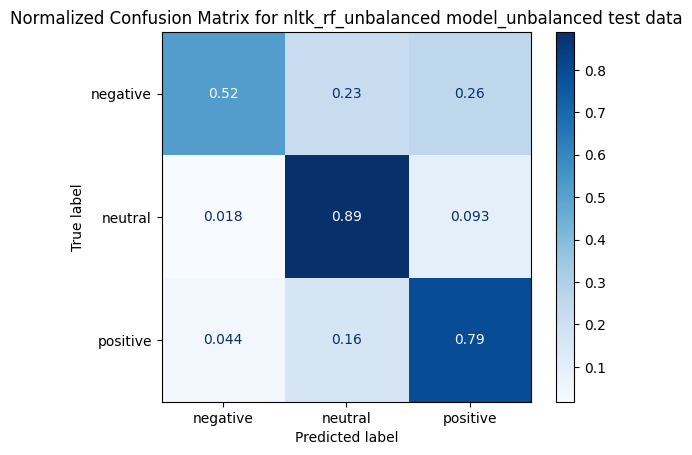

In [24]:
nltk_rf_model.fit(False)
nltk_rf_model.evaluate(False, False)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   5.3s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=  23.4s
Classification Report for nltk_rf_balanced model_balanced test data:
              precision    recall  f1-score   support

    negative       0.92      0.94      0.93      1657
     neutral       0.82      0.95      0.88      1621
    positive       0.91      0.76      0.83      1700

    accuracy                           0.88      4978
   macro avg       0.88      0.88      0.88      4978
weighted avg       0.88      0.88      0.88      4978

Confusion Matrix for nltk_rf_balanced model_balanced test data:
[[0.93964997 0.02655401 0.03379602]
 [0.00925355 0.94941394 0.04133251]
 [0.07117647 0.17235294 0.75647059]]
['negative', 'neutral', 'positive']


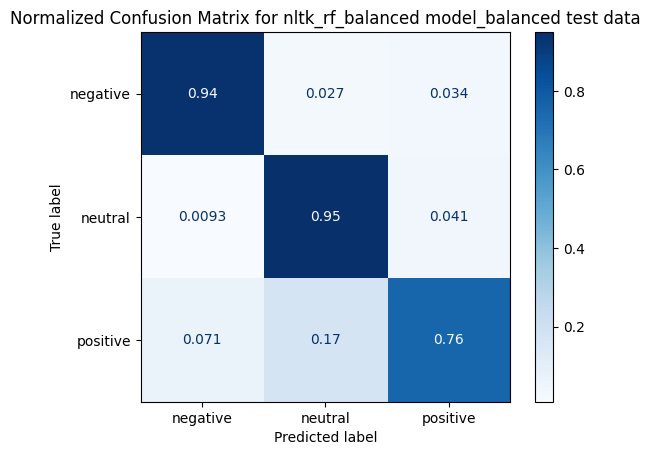

In [25]:
nltk_rf_model.fit(True)
nltk_rf_model.evaluate(True, True)

Classification Report for nltk_rf_balanced model_unbalanced test data:
              precision    recall  f1-score   support

    negative       0.95      0.93      0.94       745
     neutral       0.94      0.95      0.94      1298
    positive       0.96      0.96      0.96      1666

    accuracy                           0.95      3709
   macro avg       0.95      0.95      0.95      3709
weighted avg       0.95      0.95      0.95      3709

Confusion Matrix for nltk_rf_balanced model_unbalanced test data:
[[0.92751678 0.04161074 0.03087248]
 [0.01309707 0.95223421 0.03466872]
 [0.01260504 0.03121248 0.95618247]]
['negative', 'neutral', 'positive']


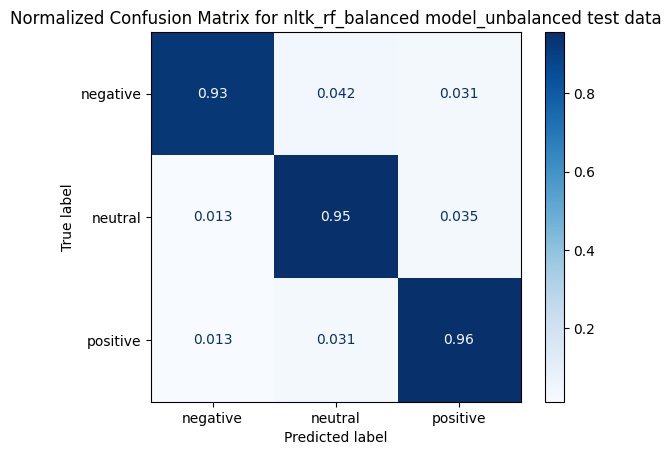

In [26]:
nltk_rf_model.evaluate(True, False)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   6.6s
[Pipeline] ........ (step 2 of 2) Processing classifier, total= 3.5min
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   5.6s
[Pipeline] ........ (step 2 of 2) Processing classifier, total= 3.6min
Classification Report for nltk_boost_n_gram_unbalanced model_unbalanced test data:
              precision    recall  f1-score   support

    negative       0.80      0.20      0.33       745
     neutral       0.60      0.82      0.69      1298
    positive       0.71      0.75      0.73      1666

    accuracy                           0.66      3709
   macro avg       0.70      0.59      0.58      3709
weighted avg       0.69      0.66      0.64      3709

Confusion Matrix for nltk_boost_n_gram_unbalanced model_unbalanced test data:
[[0.20402685 0.42281879 0.37315436]
 [0.00693374 0.8220339  0.17103236]
 [0.01740696 0.2364946  0.74609844]]
['negative', 'neutral', 'positive']


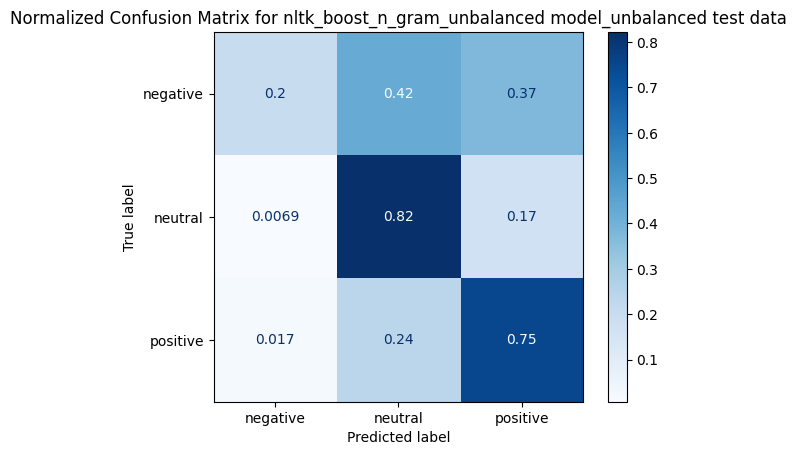

Classification Report for nltk_boost_n_gram_balanced model_unbalanced test data:
              precision    recall  f1-score   support

    negative       0.94      0.90      0.92       745
     neutral       0.90      0.94      0.92      1298
    positive       0.94      0.93      0.94      1666

    accuracy                           0.93      3709
   macro avg       0.93      0.92      0.92      3709
weighted avg       0.93      0.93      0.93      3709

Confusion Matrix for nltk_boost_n_gram_balanced model_unbalanced test data:
[[0.8966443  0.06577181 0.03758389]
 [0.01309707 0.93605547 0.05084746]
 [0.01320528 0.05462185 0.93217287]]
['negative', 'neutral', 'positive']


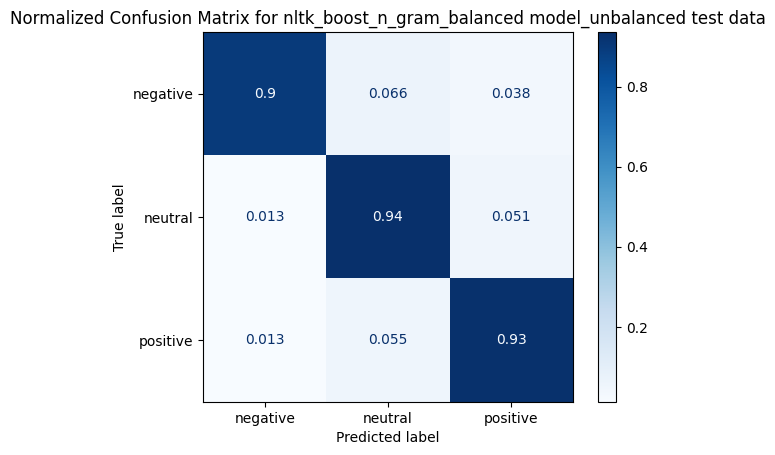

In [27]:
nltk_gb_model_ngram.fit(True)
nltk_gb_model_ngram.fit(False)
nltk_gb_model_ngram.evaluate(False, False)
nltk_gb_model_ngram.evaluate(True, False)